## Import Library

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

**Insight:**

Pada tahap ini dilakukan import seluruh library yang dibutuhkan dalam proyek. Library seperti `pandas`, `matplotlib`, dan `seaborn` digunakan untuk eksplorasi dan visualisasi data. Sementara `sklearn` digunakan untuk preprocessing, pembagian data, pelatihan model, evaluasi, dan tuning.


## Load Data

In [86]:
# Load the dataset
file_path = '../data/obesity_data.csv'
df = pd.read_csv(file_path)

# Menampilkan dataset
df.head()


,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight


**Insight:**

Dataset "Obesity Prediction" dimuat dari file CSV. Dataset ini berisi informasi usia, tinggi, berat, BMI, aktivitas fisik, gender, dan kategori obesitas. Proses awal ini penting untuk memastikan data berhasil dimuat dan siap dianalisis.


## Exploratory Data Analysis (EDA)

In [87]:
# Cek dimensi data
print(f'Dimensi dataset: {df.shape}')

Dimensi dataset: (1000, 7)


In [88]:
# Cek informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1000 non-null   int64  
 1   Gender                 1000 non-null   object 
 2   Height                 1000 non-null   float64
 3   Weight                 1000 non-null   float64
 4   BMI                    1000 non-null   float64
 5   PhysicalActivityLevel  1000 non-null   int64  
 6   ObesityCategory        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [89]:
# Cek tipe data
print(df.dtypes)

Age                        int64
Gender                    object
Height                   float64
Weight                   float64
BMI                      float64
PhysicalActivityLevel      int64
ObesityCategory           object
dtype: object


In [90]:
# Statistik deskriptif untuk fitur numerik
df.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


In [91]:
# Mengecek duplikasi data
print(f'Jumlah duplikat data: {df.duplicated().sum()}')

# Mengecek nilai null
print(f'\nJumlah missing values:\n{df.isnull().sum()}')

Jumlah duplikat data: 0

Jumlah missing values:
Age                      0
Gender                   0
Height                   0
Weight                   0
BMI                      0
PhysicalActivityLevel    0
ObesityCategory          0
dtype: int64


Tidak ada missing value dan data yang duplikat, maka tidak perlu preprocessing menghapus data duplikat dan null.

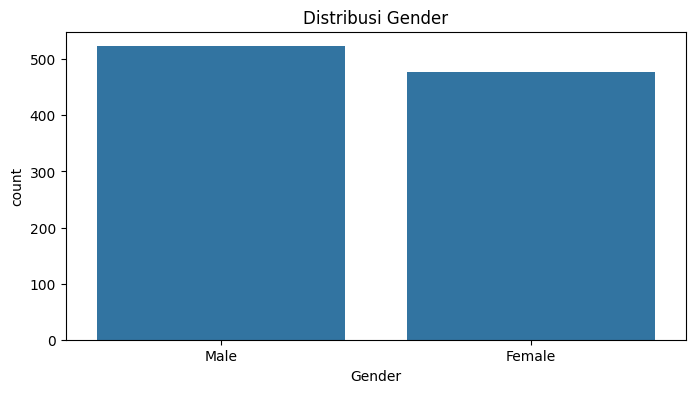

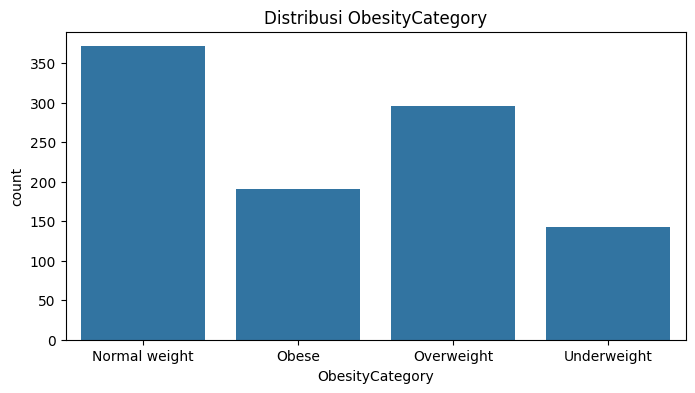

In [92]:
# Visualisasi distribusi data kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribusi {col}')
    plt.show()

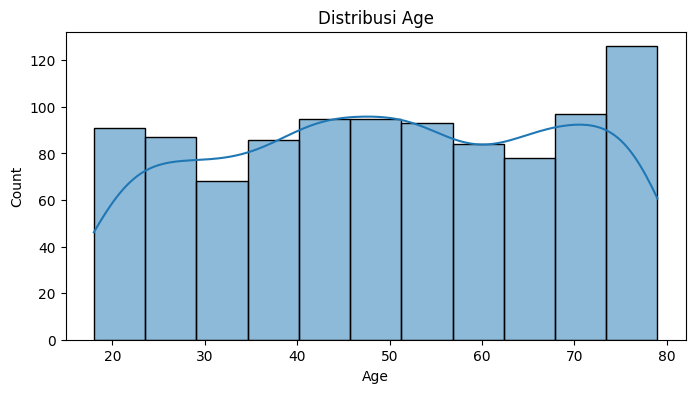

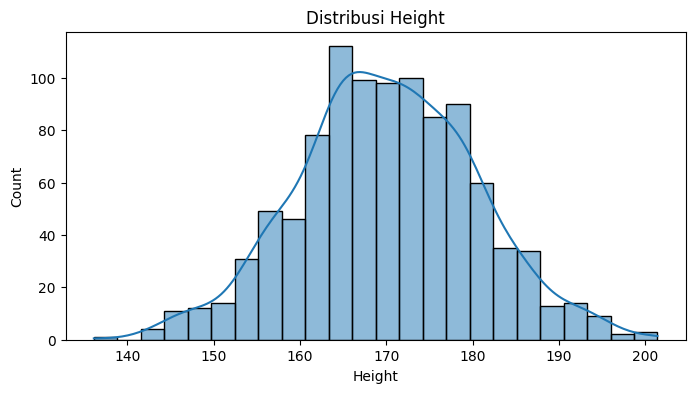

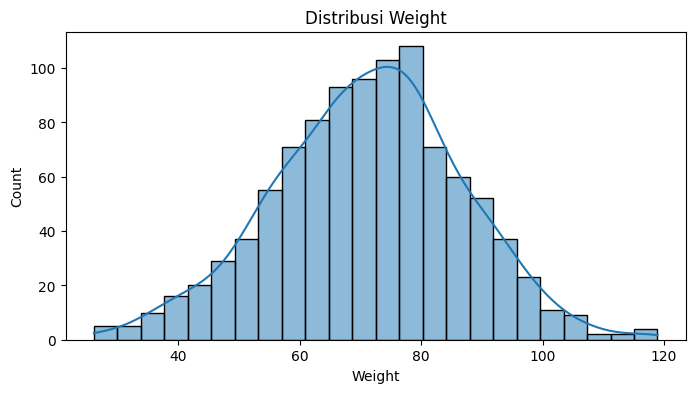

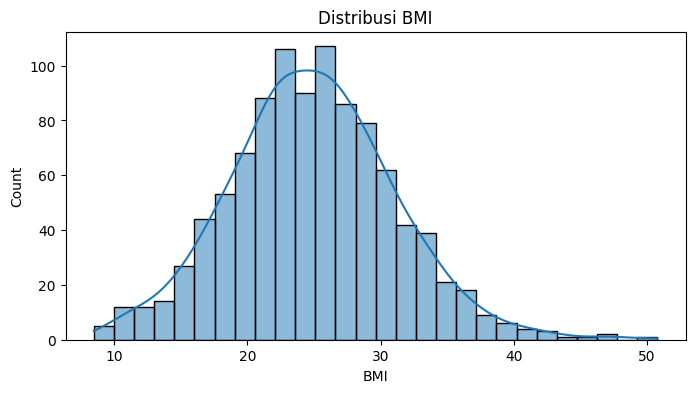

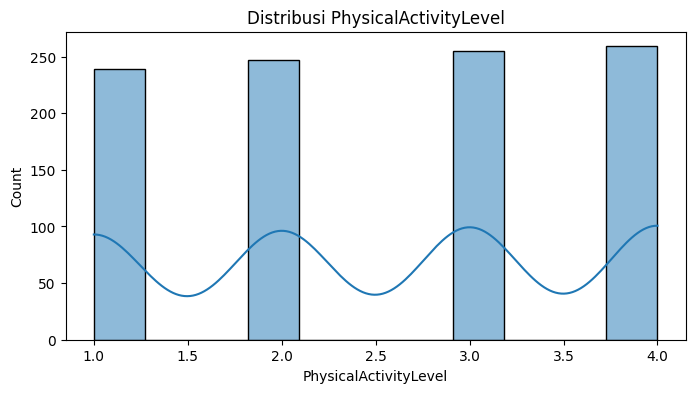

In [93]:
# Visualisasi distribusi data numerik
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

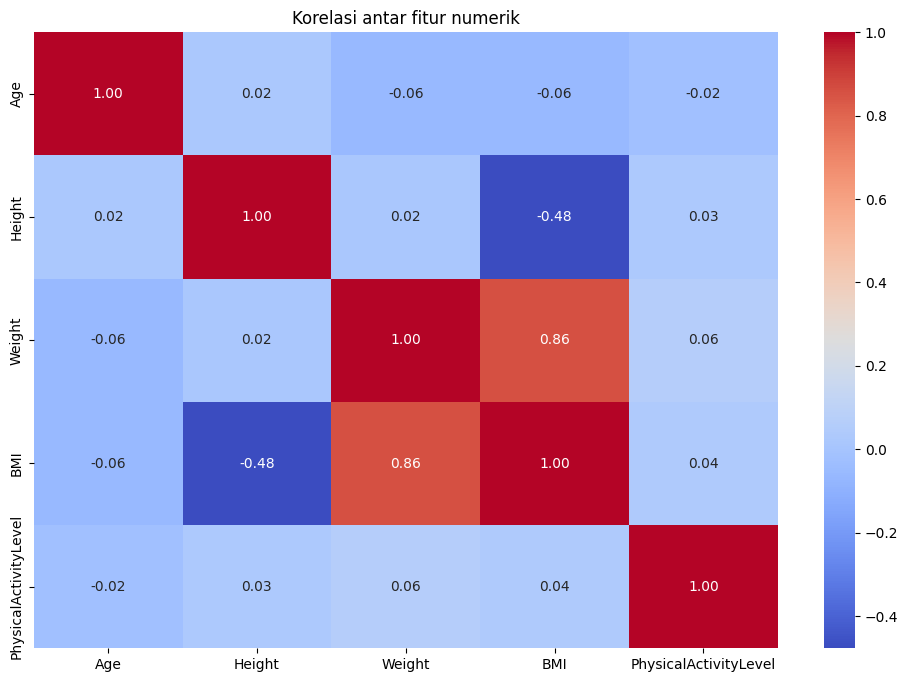

In [94]:
# Korelasi heatmap antar fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antar fitur numerik')
plt.show()

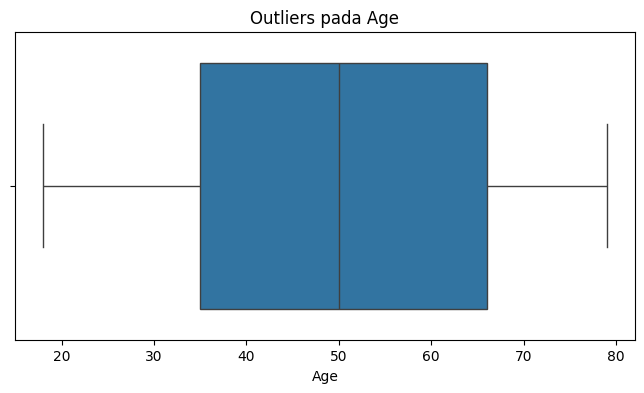

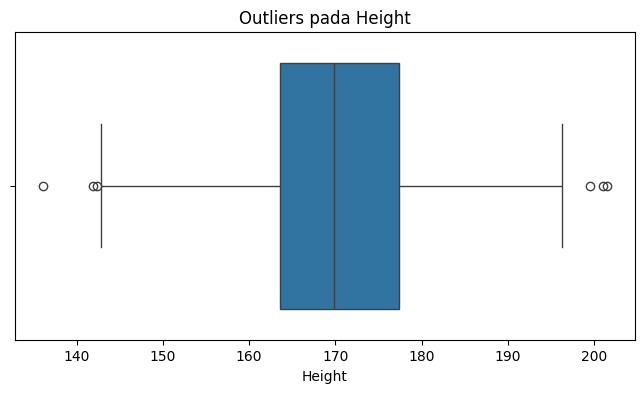

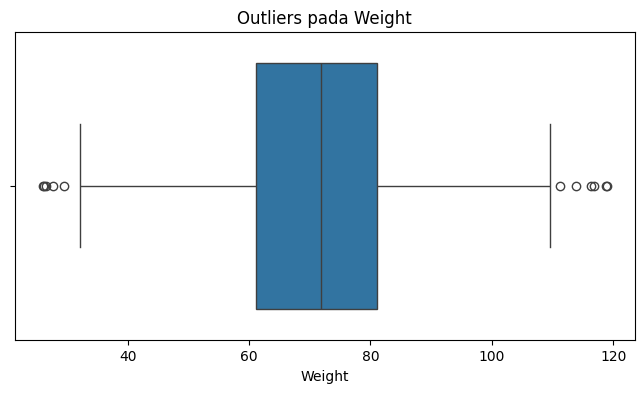

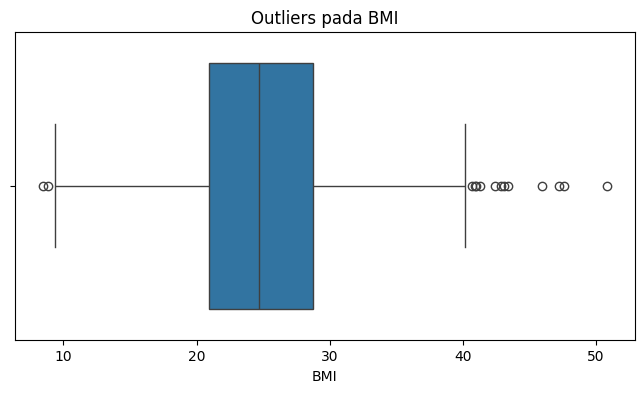

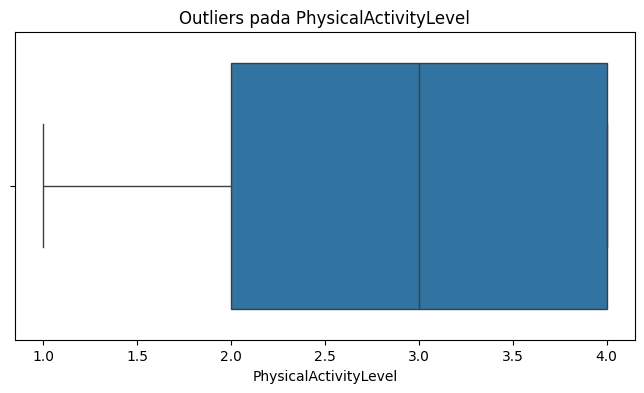

In [95]:
# Boxplot untuk mendeteksi outliers pada fitur numerik
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Outliers pada {col}')
    plt.show()

Dari visualisasi boxplot, terlihat ada outlier pada fitur BMI, tinggi badan, dan berat badan. Namun, dalam data kesehatan, nilai-nilai tersebut bisa saja wajar karena mencerminkan kondisi nyata seseorang.

Outlier tidak dihapus karena:
- Masih berada dalam batas yang mungkin terjadi secara fisiologis.
- Bisa jadi informasi penting untuk mendeteksi obesitas atau underweight.
- Model seperti Random Forest cukup kuat terhadap outlier.

**Insight:**

Tahapan ini digunakan untuk memahami struktur data, distribusi nilai, dan hubungan antar fitur:

- Dataset terdiri dari 1.000 baris dan 7 kolom.
- Tidak ditemukan missing values dan data duplikat.
- Distribusi kelas target tidak seimbang.
- Visualisasi distribusi fitur menunjukkan sebaran data normal pada BMI, berat badan, dan tinggi badan.
- Korelasi kuat terlihat antara berat badan dan BMI.

Temuan ini membantu dalam merancang strategi preprocessing dan memilih algoritma model yang tepat.

## Preprocessing Data

In [96]:
# Mengubah tipe data kolom PhysicalActivityLevel menjadi kategorikal
df['PhysicalActivityLevel'] = df['PhysicalActivityLevel'].astype('category')

df.dtypes

Age                         int64
Gender                     object
Height                    float64
Weight                    float64
BMI                       float64
PhysicalActivityLevel    category
ObesityCategory            object
dtype: object

In [97]:
# One Hot Encoding untuk fitur Gender
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Label Encoding untuk fitur PhysicalActivityLevel
label_encoder = LabelEncoder()
df['PhysicalActivityLevel'] = label_encoder.fit_transform(df['PhysicalActivityLevel'])

# Melihat hasil encoding
df.head()

,Age,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory,Gender_Male
0,56,173.575262,71.982051,23.891783,3,Normal weight,True
1,69,164.127306,89.959256,33.395209,1,Obese,True
2,46,168.072202,72.930629,25.817737,3,Overweight,False
3,32,168.459633,84.886912,29.912247,2,Overweight,True
4,60,183.568568,69.038945,20.487903,2,Normal weight,True


In [98]:
# Fit & transform
df['ObesityCategory'] = label_encoder.fit_transform(df['ObesityCategory'])

# Cek hasil mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Normal weight': 0, 'Obese': 1, 'Overweight': 2, 'Underweight': 3}


In [99]:
# Standarisasi fitur Age, Height, Weight, BMI
scaler = StandardScaler()

df[['Age', 'Height', 'Weight', 'BMI']] = scaler.fit_transform(df[['Age', 'Height', 'Weight', 'BMI']])

In [100]:
# Cek hasil preprocessing
df.head()

,Age,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory,Gender_Male
0,0.339295,0.341864,0.050076,-0.160970,3,0,True
1,1.057320,-0.574985,1.209739,1.374115,1,1,True
2,-0.213033,-0.192164,0.111266,0.150129,3,2,False
3,-0.986291,-0.154567,0.882535,0.811514,2,2,True
4,0.560226,1.311635,-0.139776,-0.710797,2,0,True


**Insight:**

Beberapa langkah preprocessing dilakukan agar data siap digunakan oleh model:

1. **Pengubahan tipe data** – Fitur `PhysicalActivityLevel` diubah menjadi kategori.
2. **Encoding** – 
   - `Gender` diencoding dengan OneHotEncoder.
   - `PhysicalActivityLevel` dan `ObesityCategory` menggunakan LabelEncoder.
3. **Standarisasi fitur numerik** – Fitur `Age`, `Height`, `Weight`, dan `BMI` distandarisasi agar memiliki skala seragam.
4. **Outlier** – Meskipun ditemukan outlier, tidak dilakukan penghapusan karena masih tergolong wajar dalam data kesehatan.

Langkah ini memastikan model dapat belajar dengan efektif dari fitur yang bersih dan terstruktur.


## Data Splitting

In [101]:
# Membagi data menjadi fitur dan target
X = df.drop('ObesityCategory', axis=1)
y = df['ObesityCategory']

# Split data ke training dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cek dimensi data training dan test
print(f'Dimensi data training: {X_train.shape}, {y_train.shape}')
print(f'Dimensi data test: {X_test.shape}, {y_test.shape}')

Dimensi data training: (800, 6), (800,)
Dimensi data test: (200, 6), (200,)


**Insight:**

Data dibagi menjadi data latih (80%) dan data uji (20%) menggunakan `train_test_split`. Ini bertujuan untuk mengevaluasi kinerja model pada data yang belum pernah dilihat sebelumnya. Stratifikasi dilakukan secara default untuk menjaga proporsi distribusi kelas target tetap konsisten.


## Modelling

In [102]:
# Model Logistic Regression
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [103]:
# Model Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Insight:**

Dua algoritma machine learning digunakan:

1. **Logistic Regression** – Sebagai baseline model. Sederhana, cepat, dan interpretatif.
2. **Random Forest** – Model yang lebih kompleks dan mampu menangani fitur non-linear.

Kedua model dilatih menggunakan data training, kemudian dievaluasi pada data testing. Ini memungkinkan perbandingan awal performa antar model.

## Evaluation

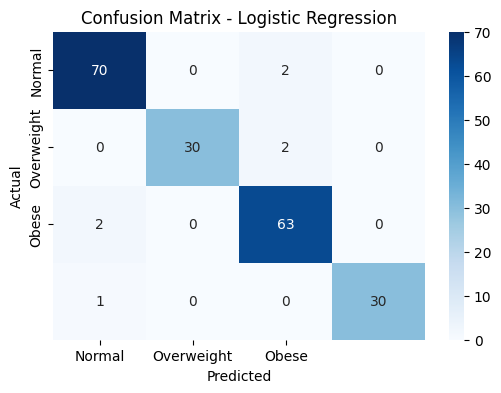

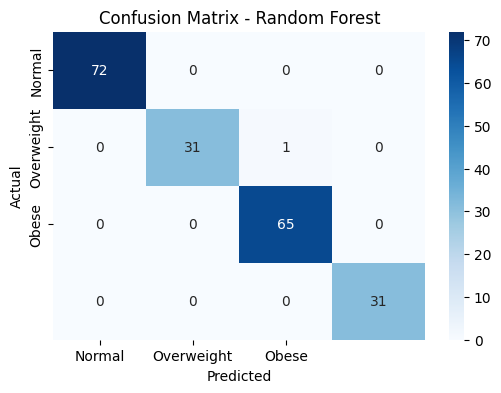

In [104]:
# Evaluasi model Logistic Regression
logreg_pred = logreg_model.predict(X_test)
logreg_report = classification_report(y_test, logreg_pred)
logreg_cm = confusion_matrix(y_test, logreg_pred)

# Evaluasi model Random Forest
rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_pred)
rf_cm = confusion_matrix(y_test, rf_pred)

# Visualisasi confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Overweight', 'Obese'], yticklabels=['Normal', 'Overweight', 'Obese'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(logreg_cm, 'Logistic Regression')
plot_confusion_matrix(rf_cm, 'Random Forest')

In [105]:
# Tabel perbandingan hasil model
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, logreg_pred), accuracy_score(y_test, rf_pred)],
    'Precision': [precision_score(y_test, logreg_pred, average='weighted'), precision_score(y_test, rf_pred, average='weighted')],
    'Recall': [recall_score(y_test, logreg_pred, average='weighted'), recall_score(y_test, rf_pred, average='weighted')],
    'F1 Score': [f1_score(y_test, logreg_pred, average='weighted'), f1_score(y_test, rf_pred, average='weighted')]
})

comparison_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.965,0.965802,0.965,0.965111
1,Random Forest,0.995,0.995076,0.995,0.994979


**Insight:**

Evaluasi dilakukan menggunakan 4 metrik utama: Accuracy, Precision, Recall, dan F1-score. Hasil evaluasi awal menunjukkan bahwa:

- Logistic Regression memiliki akurasi 96.5%.
- Random Forest mencapai akurasi 99.5%.

Confusion matrix digunakan untuk melihat kesalahan prediksi per kelas. Random Forest jelas lebih unggul karena mampu menangani kompleksitas fitur lebih baik.


## Hyperparameter Tuning

In [106]:
# Definisikan grid parameter
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Inisialisasi GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit ke data training
grid_search.fit(X_train, y_train)

# Cetak parameter terbaik
print(f'Best Parameters: {grid_search.best_params_}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


Accuracy: 0.995
Precision: 0.9950757575757575
Recall: 0.995
F1 Score: 0.994979401429783


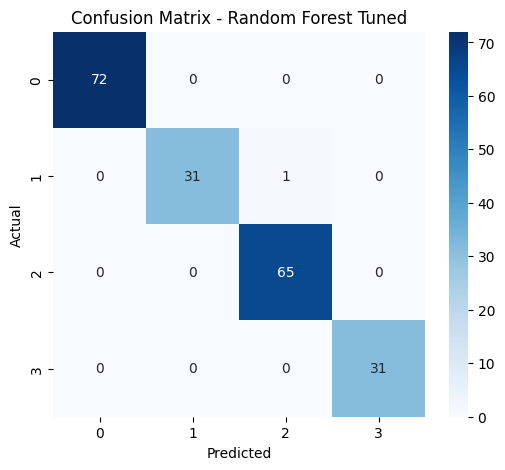

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      0.97      0.98        32
           2       0.98      1.00      0.99        65
           3       1.00      1.00      1.00        31

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [107]:
# Model terbaik
best_rf = grid_search.best_estimator_

# Prediksi dengan model terbaik
y_pred = best_rf.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report lengkap
print(classification_report(y_test, y_pred))

**Insight:**

Dilakukan penyempurnaan model Random Forest menggunakan `GridSearchCV` dengan kombinasi beberapa parameter:

- `n_estimators`
- `max_depth`
- `min_samples_split`

Tujuannya untuk menghindari overfitting dan meningkatkan performa model secara optimal. Model terbaik memiliki parameter `max_depth=10`, `min_samples_split=2`, dan `n_estimators=100`. Evaluasi menunjukkan hasil tetap konsisten tinggi setelah tuning.


## Inference

In [109]:
# Misal model terbaik hasil tuning
best_model = best_rf

# Data baru untuk inferensi
new_data = pd.DataFrame({
    'Age': [30],
    'Height': [170],
    'Weight': [70],
    'BMI': [24.2],
    'PhysicalActivityLevel': [3],
    'Gender_Male': [1]
})

# Standarisasi fitur numerik (Age, Height, Weight, BMI) harus dilakukan juga
new_data_scaled = new_data.copy()
new_data_scaled[['Age', 'Height', 'Weight', 'BMI']] = scaler.transform(new_data[['Age', 'Height', 'Weight', 'BMI']])

# Prediksi numerik
prediksi_label_num = best_model.predict(new_data_scaled)

# Ubah ke label asli
prediksi_label_str = label_encoder.inverse_transform(prediksi_label_num)

print(f"Prediksi kategori obesitas: {prediksi_label_str[0]}")

# Probabilitas prediksi
prediksi_prob = best_model.predict_proba(new_data_scaled)[0]

# Buat dictionary label: probabilitas
prob_dict = dict(zip(label_encoder.classes_, prediksi_prob))

print("\nProbabilitas prediksi per kategori:")
for label, prob in prob_dict.items():
    print(f"{label}: {prob:.4f}")

Prediksi kategori obesitas: Normal weight

Probabilitas prediksi per kategori:
Normal weight: 0.9659
Obese: 0.0000
Overweight: 0.0241
Underweight: 0.0100


**Insight:**

Model terbaik digunakan untuk memprediksi kategori obesitas pada data baru. Data distandarisasi terlebih dahulu sebelum dilakukan prediksi.

Hasil prediksi:
- Kategori obesitas: **Normal weight**
- Probabilitas tertinggi: 96.59%

Tahapan ini menunjukkan penerapan model secara praktis untuk membantu pengambilan keputusan berbasis data.
